#Self

**Nikhil Bhangare**

 

Github link:https://github.com/NikhilBhangare/Bike-sharing-demand-prediction

**Importing Library and connecting drive**



In [ ]:
# Load the necessary python libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
SeoulBikeData = pd.read_csv('/content/drive/MyDrive/SeoulBikeData (1).csv',sep=',',encoding='latin')


In [ ]:
# Print the first 5 rows of the dataframe.

SeoulBikeData.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [ ]:
SeoulBikeData.rename({"Temperature(°C)": "Temperature",  
                      "Functioning Day":"Functioning_Day",
           "Humidity(%)": "Humidity",  
           "Wind speed (m/s)": "Wind_speed",
           "Visibility (10m)": "Visibility",
           "Dew point temperature(°C)": "Dew_point_temperature",
           "Solar Radiation (MJ/m2)": "Solar_Radiation",
           "Snowfall (cm)": "Snowfall",
           "Rainfall(mm)": "Rainfall",
           "Rented Bike Count": "Rented_Bike_Count"},  
          axis = "columns", inplace = True)

In [ ]:
SeoulBikeData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   8760 non-null   object 
 1   Rented_Bike_Count      8760 non-null   int64  
 2   Hour                   8760 non-null   int64  
 3   Temperature            8760 non-null   float64
 4   Humidity               8760 non-null   int64  
 5   Wind_speed             8760 non-null   float64
 6   Visibility             8760 non-null   int64  
 7   Dew_point_temperature  8760 non-null   float64
 8   Solar_Radiation        8760 non-null   float64
 9   Rainfall               8760 non-null   float64
 10  Snowfall               8760 non-null   float64
 11  Seasons                8760 non-null   object 
 12  Holiday                8760 non-null   object 
 13  Functioning_Day        8760 non-null   object 
dtypes: float64(6), int64(4), object(4)
memory usage: 958.2+ 

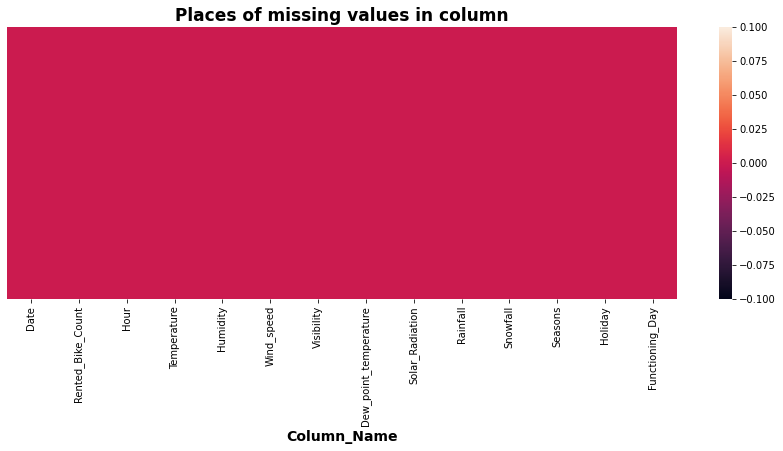

In [ ]:
# No missin Values in our dataset
plt.figure(figsize=(15, 5))
sns.heatmap(SeoulBikeData.isnull(), cbar=True, yticklabels=False)
plt.xlabel("Column_Name", size=14, weight="bold")
plt.title("Places of missing values in column",fontweight="bold",size=17)
plt.show()

**Change in Bike Renting with Change in hours**

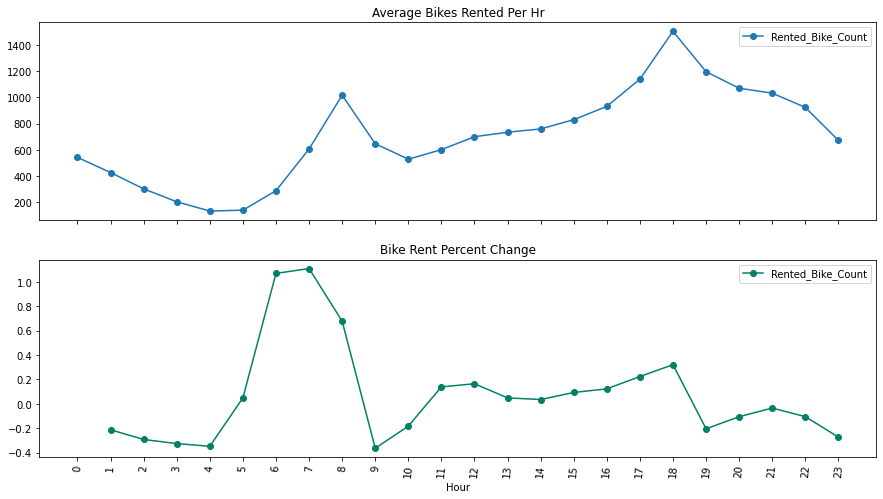

In [ ]:
# group by Hrs and get average Bikes rented, and precent change
avg_rent_hrs = SeoulBikeData.groupby('Hour')['Rented_Bike_Count'].mean()
pct_rent_hrs = SeoulBikeData.groupby('Hour')['Rented_Bike_Count'].sum().pct_change()

fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))

# plot average rent over time(hrs)
ax1 = avg_rent_hrs.plot(legend=True,ax=axis1,marker='o',title="Average Bikes Rented Per Hr")
ax1.set_xticks(range(len(avg_rent_hrs)))
ax1.set_xticklabels(avg_rent_hrs.index.tolist(), rotation=85)

# plot precent change for rent over time(hrs)
ax2 = pct_rent_hrs.plot(legend=True,ax=axis2,marker='o',rot=85,colormap="summer",title="Bike Rent Percent Change")
#ax1.set_xticks(range(len(avg_rent_hrs)))


**To get the types of seasons in our dataset:**

In [ ]:
SeoulBikeData.Seasons.unique()

array(['Winter', 'Spring', 'Summer', 'Autumn'], dtype=object)

**To get the unique holiday in our dataset **

In [ ]:
SeoulBikeData.Holiday.unique()

array(['No Holiday', 'Holiday'], dtype=object)

To get the unique number of hours in our dataset:

In [ ]:
SeoulBikeData.Hour.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])


Since, we have zero count for our dependent variable when there is no functioning day. So, to keep our dataset more intact, dropping the data where there is no functioning day.

In [ ]:

SeoulBikeData = SeoulBikeData[SeoulBikeData['Functioning_Day'] == 'Yes']
SeoulBikeData.drop('Functioning_Day', axis = 1, inplace =True)

In [ ]:
SeoulBikeData

,Date,Rented_Bike_Count,Hour,Temperature,Humidity,Wind_speed,Visibility,Dew_point_temperature,Solar_Radiation,Rainfall,Snowfall,Seasons,Holiday
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday



Assigning the categorical values to teh columns for building a model:

In [ ]:

def Functioning_Day(row):
  if str(row) == 'Yes':
    return 1
  else :
    return 0

In [ ]:
def Holiday_label(row):
  if str(row) == 'Holiday':
    return 1
  else :
    return 0

In [ ]:
SeoulBikeData['Holiday']=SeoulBikeData.apply(lambda row : Holiday_label(row['Holiday']),axis=1)

SeoulBikeData['Holiday'].value_counts()

0    8057
1     408
Name: Holiday, dtype: int64

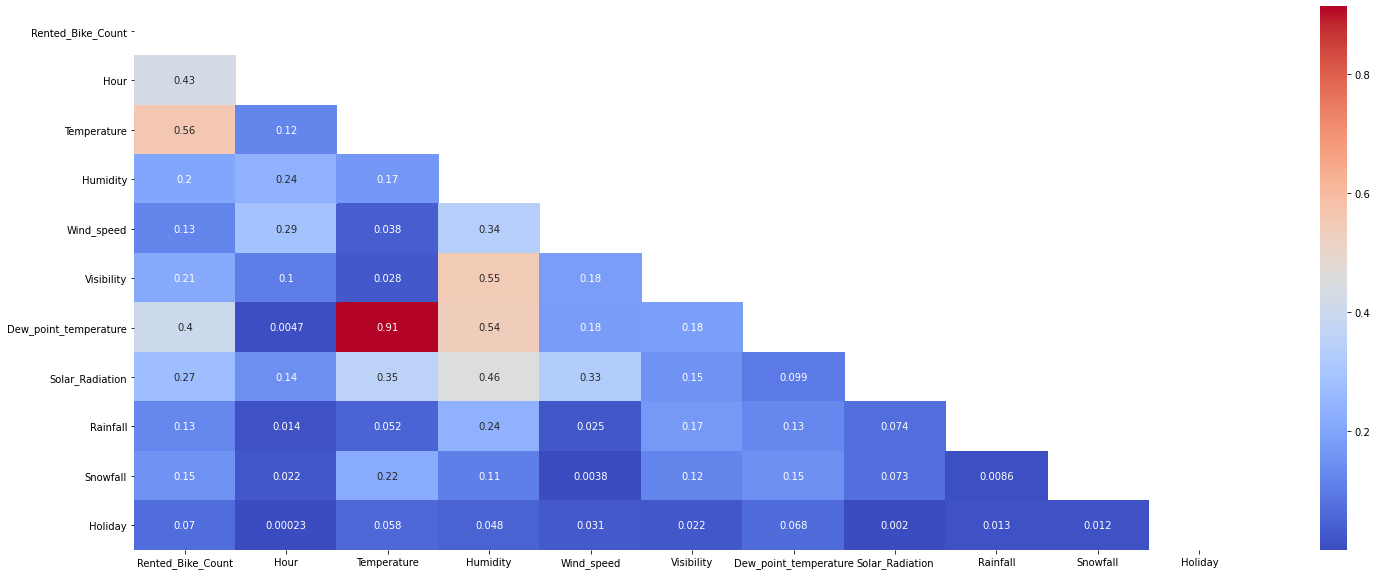

In [ ]:
plt.figure(figsize=(25,10))
cor=SeoulBikeData.corr().abs()
mask = np.triu(np.ones_like(cor, dtype=bool))
sns.heatmap(cor,mask=mask, annot=True, cmap='coolwarm')


From the above graph, we can see that Temperature and Dew_point_temperature is highy correlated, keeping the factor of 0.91 . And, then we have hour in the graph which is having good correlation with our dependent variable.

In [ ]:
SeoulBikeData.Seasons

0       Winter
1       Winter
2       Winter
3       Winter
4       Winter
         ...  
8755    Autumn
8756    Autumn
8757    Autumn
8758    Autumn
8759    Autumn
Name: Seasons, Length: 8465, dtype: object

In [ ]:
def Seasons_label(row):
  if str(row) == 'Winter':
    return 0
  elif str(row) == 'Autumn':
    return 1
  elif str(row) == 'Spring':
    return 2
  elif  str(row) == 'Summer':
    return 3

In [ ]:
SeoulBikeData['Seasons']=SeoulBikeData.apply(lambda row : Seasons_label(row['Seasons']),axis=1)

SeoulBikeData['Seasons'].value_counts()

3    2208
2    2160
0    2160
1    1937
Name: Seasons, dtype: int64

In [ ]:
SeoulBikeData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8759
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   8465 non-null   object 
 1   Rented_Bike_Count      8465 non-null   int64  
 2   Hour                   8465 non-null   int64  
 3   Temperature            8465 non-null   float64
 4   Humidity               8465 non-null   int64  
 5   Wind_speed             8465 non-null   float64
 6   Visibility             8465 non-null   int64  
 7   Dew_point_temperature  8465 non-null   float64
 8   Solar_Radiation        8465 non-null   float64
 9   Rainfall               8465 non-null   float64
 10  Snowfall               8465 non-null   float64
 11  Seasons                8465 non-null   int64  
 12  Holiday                8465 non-null   int64  
dtypes: float64(6), int64(6), object(1)
memory usage: 925.9+ KB


In [ ]:
def Function_day(row):
  if str(row) == 'Yes':
    return 1
  else :
    return 0

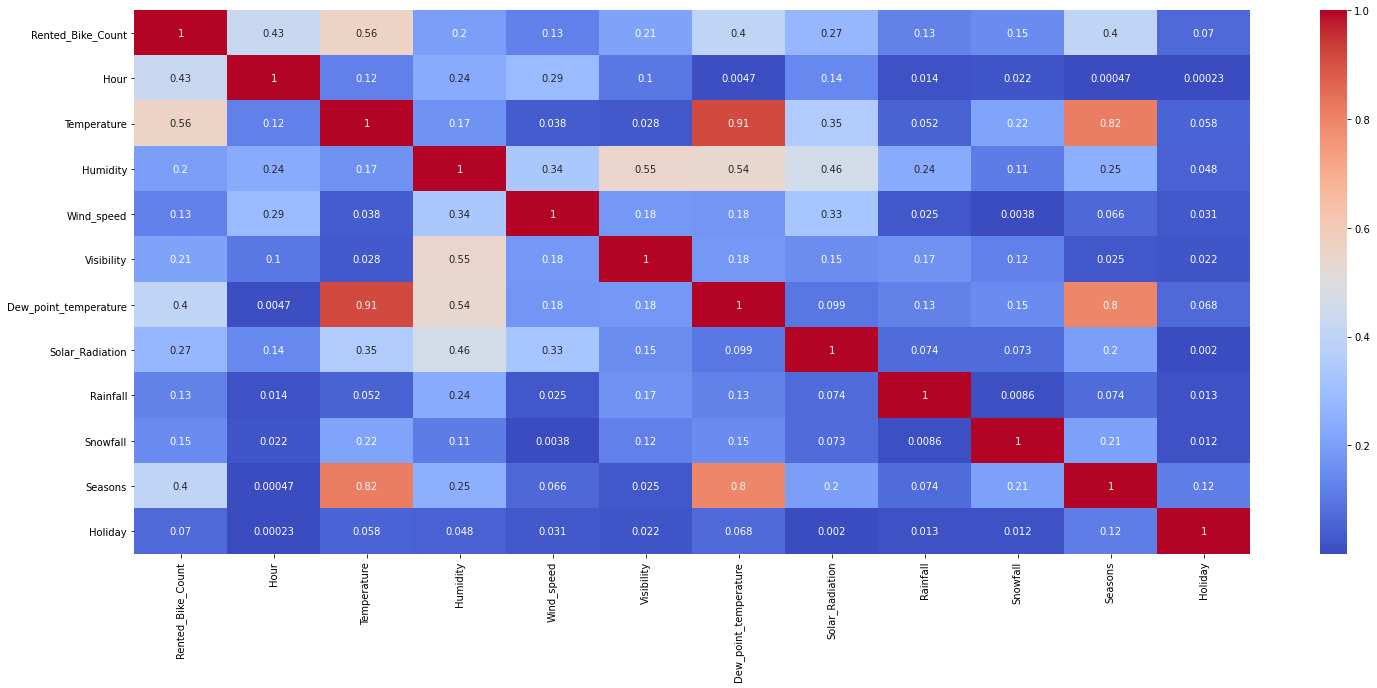

In [ ]:
plt.figure(figsize=(25,10))
sns.heatmap(SeoulBikeData.corr().abs(),annot=True,cmap='coolwarm')


**Identifying the outliers:**

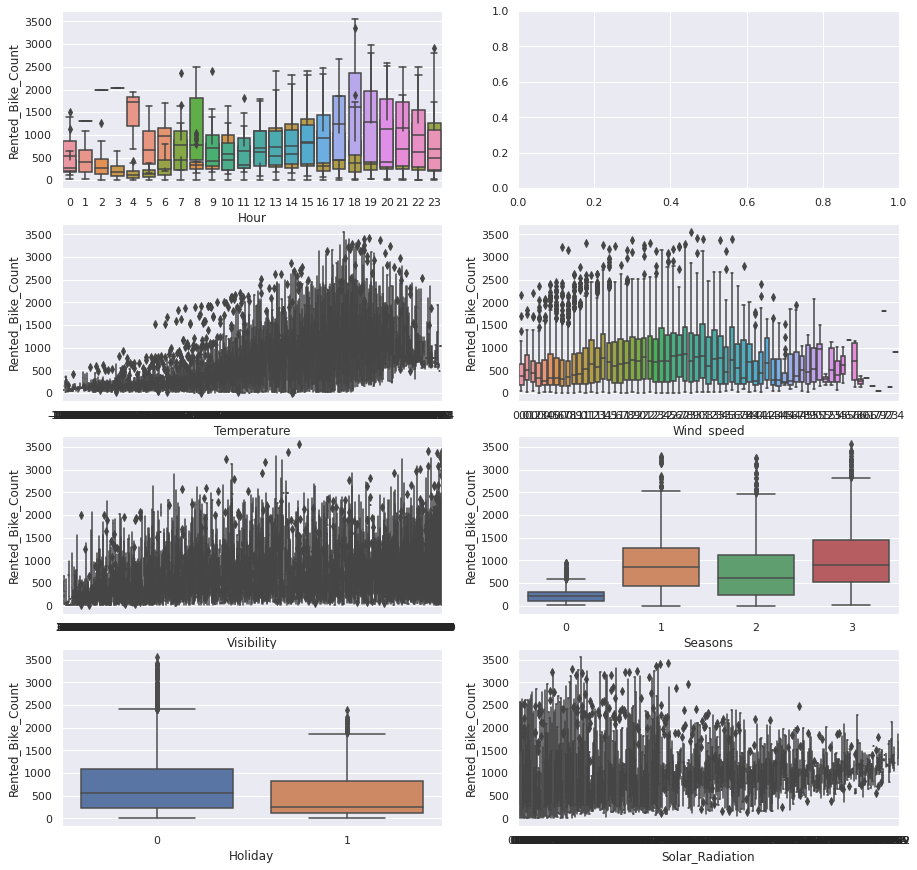

In [ ]:
sns.set(font_scale=1.0)
fig, axes = plt.subplots(nrows=4,ncols=2)
fig.set_size_inches(15, 15)
sns.boxplot(data=SeoulBikeData,y="Rented_Bike_Count",x="Humidity",orient="v",ax=axes[0][0])
sns.boxplot(data=SeoulBikeData,y="Rented_Bike_Count",x="Hour",orient="v",ax=axes[0][0])
sns.boxplot(data=SeoulBikeData,y="Rented_Bike_Count",x="Temperature",orient="v",ax=axes[1][0])
sns.boxplot(data=SeoulBikeData,y="Rented_Bike_Count",x="Wind_speed",orient="v",ax=axes[1][1])
sns.boxplot(data=SeoulBikeData,y="Rented_Bike_Count",x="Visibility",orient="v",ax=axes[2][0])
sns.boxplot(data=SeoulBikeData,y="Rented_Bike_Count",x="Seasons",orient="v",ax=axes[2][1])
sns.boxplot(data=SeoulBikeData,y="Rented_Bike_Count",x="Holiday",orient="v",ax=axes[3][0])
sns.boxplot(data=SeoulBikeData,y="Rented_Bike_Count",x="Solar_Radiation",orient="v",ax=axes[3][1])

In [ ]:
# Data for all the independent variables

SeoulBikeData = SeoulBikeData.drop(labels='Date',axis=1)
SeoulBikeData = SeoulBikeData.drop(labels='Dew_point_temperature',axis=1,)

In [ ]:
# Data for all the independent variables

X = SeoulBikeData.drop(labels='Rented_Bike_Count',axis=1)

# Data for the dependent variable

Y = SeoulBikeData['Rented_Bike_Count']


from sklearn.model_selection import train_test_split

Since , Date and Dew_point_temperature shows high correlation with our dependent variable, so dropping these two columns.

#Linear Regression

In [ ]:
# import libraray
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Lasso,Ridge

In [ ]:
# Splitting the dataset into the Training set and Test set

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)

In [ ]:
regressor = LinearRegression()
regressor.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:

X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((6348, 10), (2117, 10), (6348,), (2117,))

In [ ]:
regressor = LinearRegression()
regressor.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
regressor.intercept_

449.33004053728746

In [ ]:
regressor.coef_

array([ 2.82772556e+01,  3.33357396e+01, -7.57490553e+00,  6.55798124e+00,
        2.73253606e-02, -8.56811366e+01, -6.43327747e+01,  1.83131441e+01,
       -9.89525856e+00, -1.27441560e+02])

In [ ]:
y_pred_train=regressor.predict(X_train)


In [ ]:
y_pred=regressor.predict(X_test)

**Evaluation Matrix**

In [ ]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,accuracy_score

In [ ]:
r2_score(Y_test, y_pred)

0.5073055437091121

In [ ]:
print("Adjusted R2 : ",1-(1-r2_score((Y_test), (y_pred)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

Adjusted R2 :  0.5049660638596776


In [ ]:
MSE  = mean_squared_error(Y_test, y_pred)
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

MSE : 198793.5341180045
RMSE : 445.8626852720515


In [ ]:
MAE  = mean_absolute_error(Y_test, y_pred)
print("MAE :" , MAE)


MAE : 333.68919457334323


Text(0, 0.5, 'Predicted')

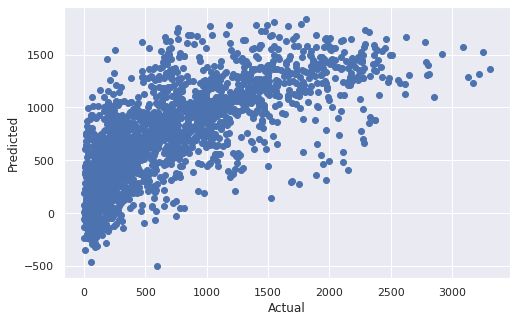

In [ ]:

plt.scatter(Y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

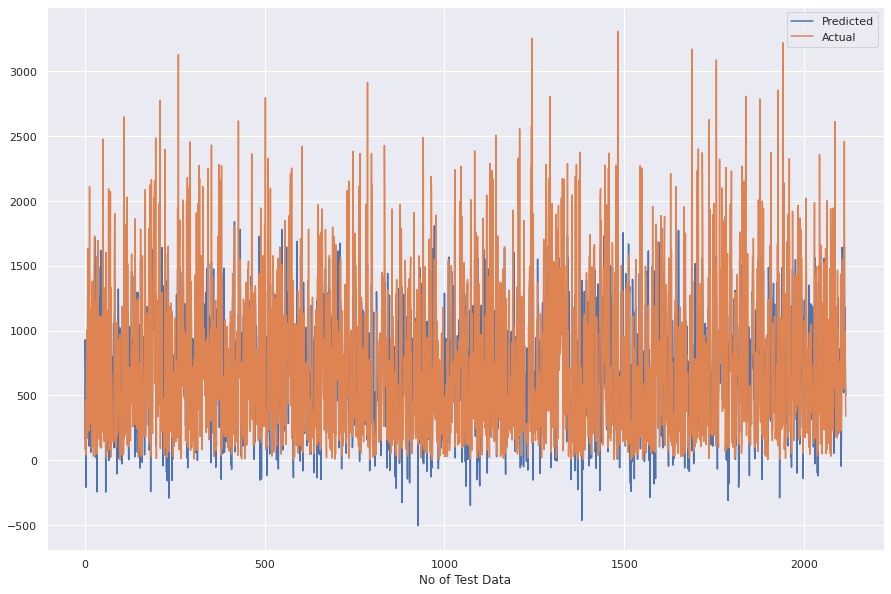

In [ ]:

plt.figure(figsize=(15,10))
plt.plot(y_pred)
plt.plot(np.array(Y_test))
plt.legend(["Predicted","Actual"])
plt.xlabel('No of Test Data')
plt.show()


#Lasso Regression

In [ ]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, Y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
y_pred=lasso.predict(X_test)

In [ ]:
r2_score(Y_test, y_pred)

0.5073052224328767

In [ ]:
MSE  = mean_squared_error(Y_test, y_pred)
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

MSE : 198793.663747306
RMSE : 445.86283064111325


In [ ]:
MAE  = mean_absolute_error(Y_test, y_pred)
print("MAE :" , MAE)

MAE : 333.68926336070683



#Ridge Rigression

In [ ]:
# Hyperparameter tuning

from sklearn.model_selection import GridSearchCV
ridge = Ridge(alpha=30)
ridge.fit(X_train,Y_train)

Ridge(alpha=30, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [ ]:
y_pred=ridge.predict(X_test)

In [ ]:
r2_score(Y_test, y_pred)

0.5070654634720594

In [ ]:

MSE  = mean_squared_error(Y_test, y_pred)
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

MSE : 198890.40226455292
RMSE : 445.97130206388044


In [ ]:
MAE  = mean_absolute_error(Y_test, y_pred)
print("MAE :" , MAE)

MAE : 333.76785647648927



#Decision Tree Regression

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()

In [ ]:
tree.fit(X_train,Y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
y_pred=tree.predict(X_test)

In [ ]:

r2_score(Y_test, y_pred)

0.7323647622936766

In [ ]:
print("Adjusted R2 : ",1-(1-r2_score((Y_test), (y_pred)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

Adjusted R2 :  0.7310939397024785


In [ ]:
MSE  = mean_squared_error(Y_test, y_pred)
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

MSE : 107986.10392064242
RMSE : 328.6123916115192


In [ ]:

MAE  = mean_absolute_error(Y_test, y_pred)
print("MAE :" , MAE)

MAE : 189.90930562116202


Text(0, 0.5, 'Predicted')

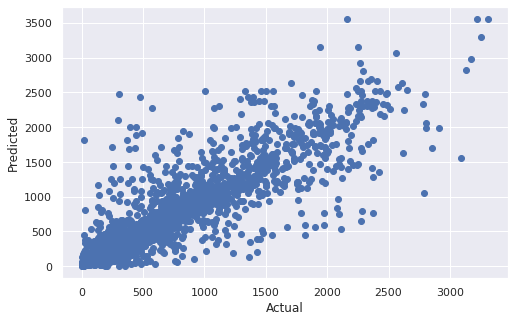

In [ ]:

plt.scatter(Y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

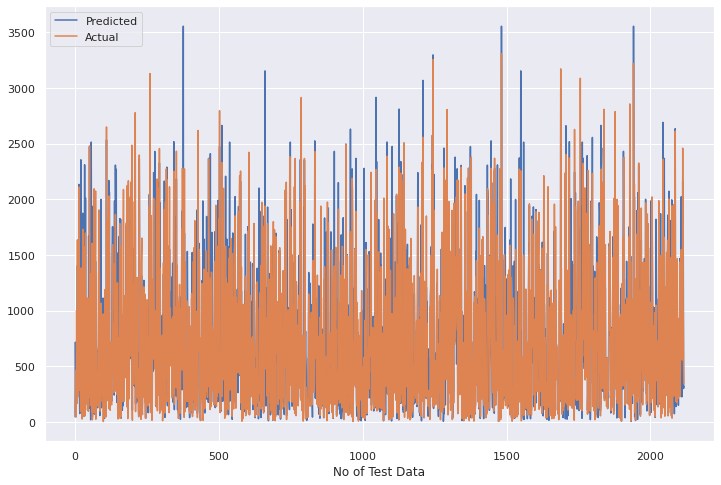

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(y_pred)
plt.plot(np.array(Y_test))
plt.legend(["Predicted","Actual"])
plt.xlabel('No of Test Data')
plt.show()

In [ ]:
tree.feature_importances_

array([0.31905711, 0.35588286, 0.12074742, 0.02012238, 0.01792267,
       0.1014761 , 0.01877544, 0.00111842, 0.04203009, 0.00286752])

In [ ]:
features = X.columns
importances = tree.feature_importances_
indices = np.argsort(importances)

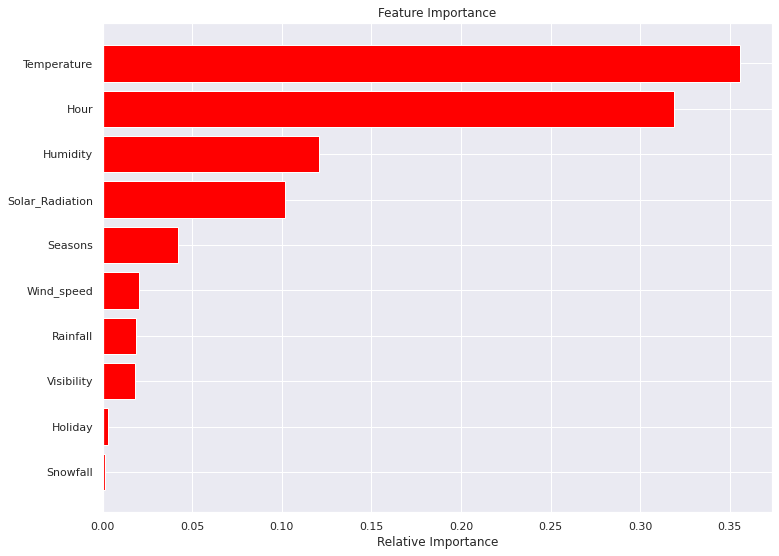

In [ ]:
plt.figure(figsize=(12,9))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='red', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#GradiantBoosting Algorithm

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
ensemble = GradientBoostingRegressor()

In [ ]:
ensemble.fit(X_train,Y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:

y_pred=ensemble.predict(X_test)

In [ ]:
r2_score(Y_test, y_pred)

0.8316669383302523

In [ ]:
print("Adjusted R2 : ",1-(1-r2_score((Y_test), (y_pred)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

Adjusted R2 :  0.8308676360431215


In [ ]:
MSE  = mean_squared_error(Y_test, y_pred)
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

MSE : 67919.42513450203
RMSE : 260.6135551626239


In [ ]:
MAE  = mean_absolute_error(Y_test, y_pred)
print("MAE :" , MAE)

MAE : 174.0811347280319


Text(0, 0.5, 'Predicted')

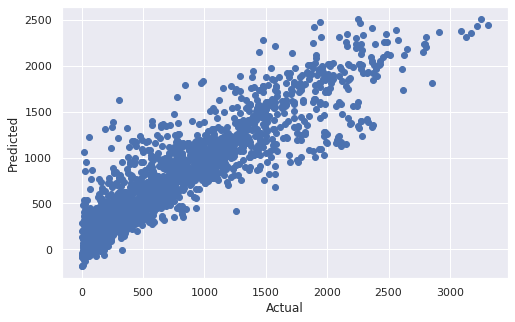

In [ ]:
plt.scatter(Y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

#RandomForest Algorithm


Parameter tuning on ‘n_estimators’, ‘max_depth’ and ‘min_samples_leaf’ parameters.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
ensemble_regressior = RandomForestRegressor()

In [ ]:
ensemble_regressior.fit(X_train,Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
y_pred=ensemble_regressior.predict(X_test)

In [ ]:
r2_score(Y_test, y_pred)

0.8486515722898158

In [ ]:
print("Adjusted R2 : ",1-(1-r2_score((Y_test), (y_pred)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

Adjusted R2 :  0.8479329187869185


In [ ]:
MSE  = mean_squared_error(Y_test, y_pred)
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

MSE : 61066.4245224374
RMSE : 247.11621663184593


In [ ]:
MAE  = mean_absolute_error(Y_test, y_pred)
print("MAE :" , MAE)

MAE : 151.32088804912613


Text(0, 0.5, 'Predicted')

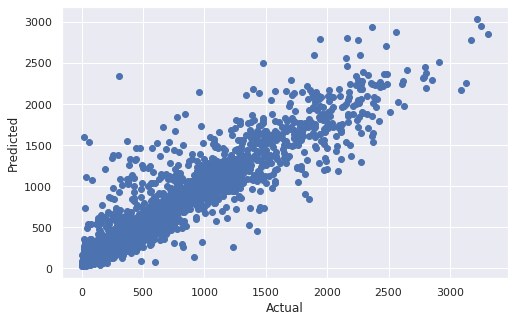

In [ ]:
plt.scatter(Y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

#XGBoost

In [ ]:
import xgboost as xgb

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.33, random_state=42)
dreg= xgb.XGBRegressor(
                        booster= 'gbtree',
                        colsample_bylevel= 1,
                        colsample_bynode= 1,
                        colsample_bytree= 0.7,
                        eta= 0.004,
                        gamma= 0,
                        importance_type= 'gain',
                        learning_rate= 0.1,
                        max_delta_step= 0,
                        max_depth= 9,
                        min_child_weight= 10,
                        n_estimators= 100,
                        n_jobs= 1,
                        objective= 'reg:linear',
                        random_state= 0,
                        reg_alpha= 0,
                        reg_lambda= 1,
                        scale_pos_weight= 1,
                        subsample= 1,
                        verbosity= 1)
dreg.fit(X_train, Y_train)
y_pred = dreg.predict(X_test)
#Find R-squared value
r2 = r2_score(Y_test, y_pred)
# Find Adjusted R-squared value
adj_r2=1-(1-r2_score(Y_test, y_pred))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
train_score = dreg.score(X_train, Y_train)
test_score = dreg.score(X_test,Y_test)
print(f'Train score: {train_score}')
print(f'Test score: {test_score}')
r2

[07:49:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train score: 0.9669850295574288
Test score: 0.8662260483087465


0.8662260483087465

In [ ]:

r2

0.8662260483087465

In [ ]:
adj_r2

0.8657453657658387

In [ ]:

MSE  = mean_squared_error(Y_test, y_pred)
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

MSE : 54287.031544213925
RMSE : 232.9957758076612


In [ ]:
MAE  = mean_absolute_error(Y_test, y_pred)
print("MAE :" , MAE)

MAE : 143.48340080681663


Cat boost

In [ ]:
!pip install catboost

     |████████████████████████████████| 69.2MB 41kB/s 


In [ ]:

from catboost import CatBoostRegressor
import timeit

from sklearn.datasets import make_regression

In [ ]:
model = CatBoostRegressor(
    iterations=100,
    learning_rate=0.03
  )

In [ ]:
model.fit(
      X_train, Y_train,
      eval_set=(X_test, Y_test),
      verbose=10);

0:	learn: 631.5916137	test: 624.0208755	best: 624.0208755 (0)	total: 49.8ms	remaining: 4.93s
10:	learn: 528.0301750	test: 520.7406579	best: 520.7406579 (10)	total: 74.9ms	remaining: 606ms
20:	learn: 455.0097540	test: 448.0552316	best: 448.0552316 (20)	total: 100ms	remaining: 377ms
30:	learn: 403.2104051	test: 396.9966781	best: 396.9966781 (30)	total: 126ms	remaining: 281ms
40:	learn: 365.9420642	test: 360.2023266	best: 360.2023266 (40)	total: 152ms	remaining: 219ms
50:	learn: 338.5169147	test: 334.2317422	best: 334.2317422 (50)	total: 178ms	remaining: 171ms
60:	learn: 320.1525756	test: 316.5654578	best: 316.5654578 (60)	total: 203ms	remaining: 130ms
70:	learn: 305.1875732	test: 302.5257141	best: 302.5257141 (70)	total: 228ms	remaining: 93.2ms
80:	learn: 294.1659226	test: 292.0153816	best: 292.0153816 (80)	total: 258ms	remaining: 60.5ms
90:	learn: 284.8812130	test: 283.4881271	best: 283.4881271 (90)	total: 288ms	remaining: 28.5ms
99:	learn: 278.0065496	test: 277.2139971	best: 277.213997

In [ ]:
def train_on_cpu():  
  model = CatBoostRegressor(
    iterations=100,
    learning_rate=0.03
  )
  
  model.fit(
      X_train, Y_train,
      eval_set=(X_test, Y_test),
      verbose=10
  );   
      
cpu_time = timeit.timeit('train_on_cpu()', 
                         setup="from __main__ import train_on_cpu", 
                         number=1)

print('Time to fit model on CPU: {} sec'.format(int(cpu_time)))

0:	learn: 631.5916137	test: 624.0208755	best: 624.0208755 (0)	total: 3ms	remaining: 297ms
10:	learn: 528.0301750	test: 520.7406579	best: 520.7406579 (10)	total: 28.4ms	remaining: 230ms
20:	learn: 455.0097540	test: 448.0552316	best: 448.0552316 (20)	total: 53.8ms	remaining: 202ms
30:	learn: 403.2104051	test: 396.9966781	best: 396.9966781 (30)	total: 96.8ms	remaining: 215ms
40:	learn: 365.9420642	test: 360.2023266	best: 360.2023266 (40)	total: 122ms	remaining: 176ms
50:	learn: 338.5169147	test: 334.2317422	best: 334.2317422 (50)	total: 148ms	remaining: 142ms
60:	learn: 320.1525756	test: 316.5654578	best: 316.5654578 (60)	total: 173ms	remaining: 111ms
70:	learn: 305.1875732	test: 302.5257141	best: 302.5257141 (70)	total: 206ms	remaining: 84.3ms
80:	learn: 294.1659226	test: 292.0153816	best: 292.0153816 (80)	total: 234ms	remaining: 54.9ms
90:	learn: 284.8812130	test: 283.4881271	best: 283.4881271 (90)	total: 258ms	remaining: 25.5ms
99:	learn: 278.0065496	test: 277.2139971	best: 277.2139971

In [ ]:
# Predicting the Test set results

y_pred = model.predict(X_test)

In [ ]:
import math
math.sqrt(mean_squared_error(Y_test, y_pred))

277.2139971320696

In [ ]:
r2_score(Y_test, y_pred)

0.8106323579478576

In [ ]:
adj_r2

0.8657453657658387

In [ ]:
MSE  = mean_squared_error(Y_test, y_pred)
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

MSE : 76847.60020593909
RMSE : 277.2139971320696


In [ ]:

MAE  = mean_absolute_error(Y_test, y_pred)
print("MAE :" , MAE)

MAE : 192.4843791565666


In [ ]:

# Validating Assumptions

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error
def print_metrics(actual, predicted):
  print('MSE is {}'.format(mean_squared_error(actual, predicted)))
  print('RMSE is {}'.format(math.sqrt(mean_squared_error(actual, predicted))))
  print('RMSE is {}'.format(r2_score(actual, predicted)))
  print('MAE is {}'.format(mean_absolute_error(actual, predicted)))
  print('MAPE is {}'.format(np.mean(np.abs((actual - predicted) / actual)) * 100))

In [ ]:
# Evaluation of training Data

print_metrics(Y_train, y_train_pred)

MSE is 77287.64163720791
RMSE is 278.0065496300544
RMSE is 0.8141411569704782
MAE is 195.13166380692934
MAPE is 89.5093241100718


In [ ]:
# Test dataset metrics

print_metrics(Y_test, y_test_pred)

MSE is 76847.60020593909
RMSE is 277.2139971320696
RMSE is 0.8106323579478576
MAE is 192.4843791565666
MAPE is 82.15351168777153


#Grid Search CV on XGboost algorithm

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb

xgb = xgb.XGBRegressor(random_state=0)

In [ ]:
params = {"min_child_weight":[10,20], 
            'eta': [0.004,0.04,4,40], 
            'colsample_bytree':[0.7], 
            'max_depth': [7,9,11],
          
          }

In [ ]:
reg_gs = GridSearchCV(xgb,param_grid=params, verbose=1,cv=3)
reg_gs.fit(X, Y)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[07:49:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[07:49:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:49:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:49:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:49:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:49:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:49:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:49:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:49:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   52.5s finished


[07:50:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.7], 'eta': [0.004, 0.04, 4, 40],
                         'max_depth': [7, 9, 11],
 

In [ ]:

reg_gs.best_estimator_.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.7,
 'eta': 0.004,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 9,
 'min_child_weight': 20,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [ ]:
reg_optimal_model =reg_gs.best_estimator_

In [ ]:
train_preds = reg_optimal_model.predict(X_train)
test_preds = reg_optimal_model.predict(X_test)

In [ ]:
reg_optimal_model.score(X_test,Y_test)

0.9447339650042254

#For Train dataset:

In [ ]:
#Find R-squared value

r2 = r2_score(Y_test, test_preds)

# Find Adjusted R-squared value

adj_r2=1-(1-r2_score(Y_test, test_preds))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))

In [ ]:
r2

0.9447339650042254

In [ ]:
adj_r2

0.9445353806168888

# For Train dataset

In [ ]:
#Find R-squared value
r2 = r2_score(Y_train, train_preds)
# Find Adjusted R-squared value
adj_r2=1-(1-r2_score(Y_train, train_preds))*((X_train.shape[0]-1)/(X_train.shape[0]-X_test.shape[1]-1))

In [ ]:
r2

0.9485426027944392

In [ ]:
adj_r2

0.9484516886651008

**We have nearly same r2 score for both the datasets,train and test which leads towards optimal model.**

#Principal Component Analysis

In [ ]:

# import libraries for PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=7)
# X = df.drop('MEDV',axis=1)
X_pca = pca.fit_transform(X)

In [ ]:
print(pca.components_)

[[-1.18153753e-03 -5.59596564e-04  1.84611219e-02 -3.06604467e-04
  -9.99828599e-01 -2.18479636e-04  3.14923571e-04  8.95836866e-05
   4.58745002e-05 -7.81710901e-06]
 [ 8.33484125e-02 -2.63955751e-01 -9.60011368e-01  1.67888430e-02
  -1.76904292e-02  1.77698494e-02 -1.09468539e-02 -2.22004993e-04
  -2.69764325e-02  6.18464483e-04]
 [ 1.75779308e-01  9.49682398e-01 -2.46810716e-01  7.85664204e-03
  -5.30502966e-03  3.86761950e-02 -2.27616638e-04 -8.75922136e-03
   6.80171585e-02 -7.87782427e-04]
 [ 9.80127499e-01 -1.46635537e-01  1.26154097e-01  3.19024579e-02
   1.25012311e-03 -1.46935937e-02  1.32003516e-02  4.53682891e-03
  -2.24317823e-02 -7.44074035e-06]
 [-1.74296932e-02 -4.09252963e-03 -7.65691228e-03  1.85185111e-01
   1.19674311e-04  6.47221273e-02  9.80180878e-01 -5.56436118e-03
   1.87828819e-02  1.54052880e-04]
 [ 2.77500231e-02  9.37309922e-03 -2.32676313e-02 -9.39140374e-01
  -6.10039551e-05 -2.76808750e-01  1.96361176e-01 -2.89034911e-02
  -2.42464358e-02 -3.45784200e-03

In [ ]:
print(pca.explained_variance_)

[3.71070493e+05 3.08269408e+02 1.37489840e+02 4.26688625e+01
 1.19646116e+00 9.34367180e-01 4.27018283e-01]


In [ ]:
df_pca = pd.DataFrame(X_pca,columns=['F1','F2','F3','F4','F5','F6','F7'])
df_pca['Rented_Bike_Count'] = SeoulBikeData['Rented_Bike_Count']

In [ ]:

df_pca.head()

,F1,F2,F3,F4,F5,F6,F7,Rented_Bike_Count
0,-566.396379,14.111535,-16.994444,-10.547954,0.380509,-0.308301,-0.183059,254.0
1,-566.378502,13.290555,-17.361379,-9.442345,0.097391,1.008166,0.026916,204.0
2,-566.361004,12.549227,-17.905681,-8.256366,0.111387,0.820133,-0.007089,173.0
3,-566.343582,11.723677,-18.167434,-7.123947,0.068601,0.916655,0.015741,107.0
4,-566.419149,15.617784,-16.803476,-6.633100,0.340239,-0.275446,-0.257752,78.0


In [ ]:
df_pca.corr().abs()

,F1,F2,F3,F4,F5,F6,F7,Rented_Bike_Count
F1,1.000000e+00,1.589416e-16,1.689959e-16,1.809591e-16,1.990294e-16,8.394510e-18,9.107223e-17,0.099815
F2,1.589416e-16,1.000000e+00,1.831045e-16,1.443886e-16,6.578919e-17,7.508658e-17,1.063509e-16,0.130500
F3,1.689959e-16,1.831045e-16,1.000000e+00,2.276461e-16,8.335038e-18,2.175697e-17,2.399591e-16,0.529936
F4,1.809591e-16,1.443886e-16,2.276461e-16,1.000000e+00,3.812628e-17,1.355795e-16,3.724418e-17,0.217682
F5,1.990294e-16,6.578919e-17,8.335038e-18,3.812628e-17,1.000000e+00,7.167603e-16,1.671189e-16,0.006351
F6,8.394510e-18,7.508658e-17,2.175697e-17,1.355795e-16,7.167603e-16,1.000000e+00,2.062893e-16,0.038303
F7,9.107223e-17,1.063509e-16,2.399591e-16,3.724418e-17,1.671189e-16,2.062893e-16,1.000000e+00,0.066110
Rented_Bike_Count,9.981496e-02,1.304999e-01,5.299355e-01,2.176819e-01,6.350610e-03,3.830251e-02,6.610950e-02,1.000000


In [ ]:
#Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):
 
   # Calculating VIF
   vif = pd.DataFrame()
   vif["variables"] = X.columns
   vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
 
   return(vif)

In [ ]:

calc_vif(df_pca[[feature for feature in df_pca.describe().columns if feature not in ['Rented_Bike_Count']]])

,variables,VIF
0,F1,1.0
1,F2,1.0
2,F3,1.0
3,F4,1.0
4,F5,1.0
5,F6,1.0
6,F7,1.0


<Figure size 1152x1728 with 0 Axes>

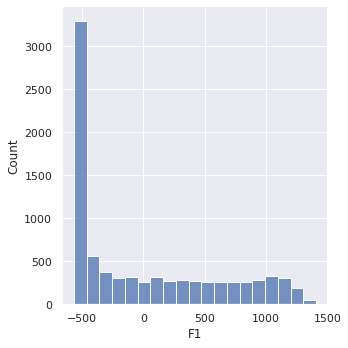

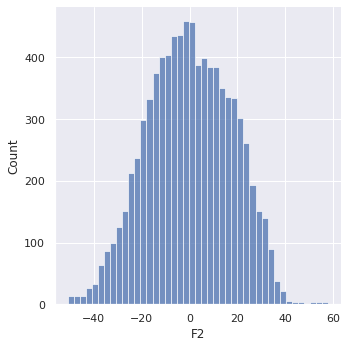

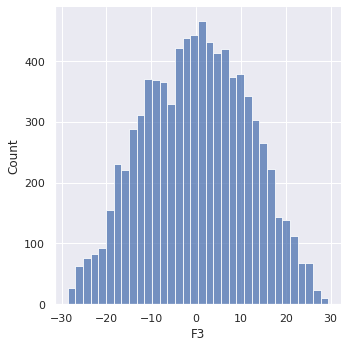

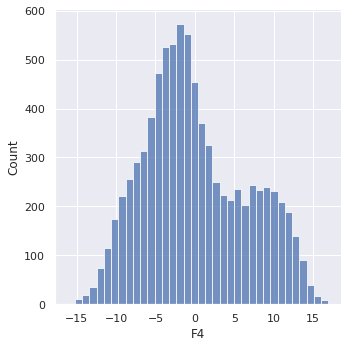

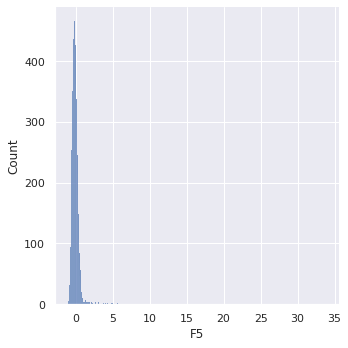

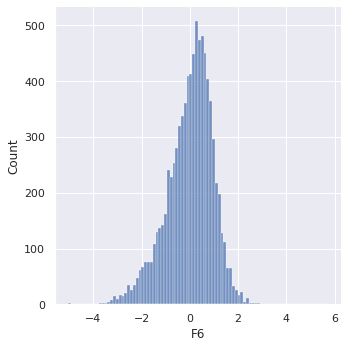

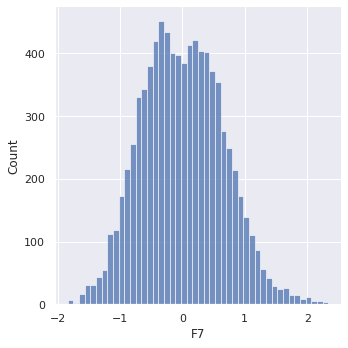

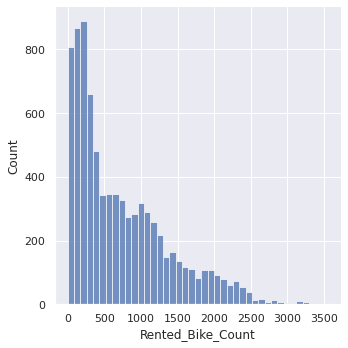

In [ ]:

# Lets look at the distribution plot of the features
pos = 1
fig = plt.figure(figsize=(16,24))
for i in df_pca.columns:
    pos = pos + 1
    sns.displot(df_pca[i])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,r2_score,mean_absolute_error,mean_squared_error

In [ ]:

X_train,X_test,Y_train,Y_test = train_test_split(X , Y, test_size=0.20)


print("Shape of Train data set is",X_train.shape,Y_train.shape)
print("Shape of X_test is ",X_test.shape,Y_test.shape)

Shape of Train data set is (6772, 10) (6772,)
Shape of X_test is  (1693, 10) (1693,)


In [ ]:
### Cross validation

lasso = Lasso()
parameters = {'alpha': [1e-7,1e-3,1e-2,1e-1,1,5,10,20,100]}
regressor = GridSearchCV(lasso, parameters, cv=8)
regressor.fit(X_train, Y_train)

GridSearchCV(cv=8, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-07, 0.001, 0.01, 0.1, 1, 5, 10, 20, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
optimal=regressor.best_estimator_

In [ ]:
y_pred=optimal.predict(X_test)
y_pred_train=optimal.predict(X_train)

In [ ]:

MSE  = mean_squared_error(Y_test, y_pred)
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

MSE : 215528.2807953776
RMSE : 464.2502351053552


In [ ]:
#Train datset
r2 = r2_score(Y_train, y_pred_train)
print("R2 :" ,r2)

R2 : 0.5181357054454316


In [ ]:
#test dataset
r2 = r2_score(Y_test, y_pred)
print("R2 :" ,r2)

R2 : 0.5000366168238257


#Grid Search CV on XGboost algorithm

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb

xgb = xgb.XGBRegressor(random_state=0)

In [ ]:
params = {"min_child_weight":[10,20], 
            'eta': [0.004,0.04,4,40], 
            'colsample_bytree':[0.7], 
            'max_depth': [7,9,11],
          
          }

In [ ]:
reg_gs = GridSearchCV(xgb,param_grid=params, verbose=1,cv=3)
reg_gs.fit(X, Y)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[07:50:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[07:50:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:50:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:50:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:50:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:50:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:50:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:50:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:50:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   52.6s finished


[07:51:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.7], 'eta': [0.004, 0.04, 4, 40],
                         'max_depth': [7, 9, 11],
 

In [ ]:
reg_gs.best_estimator_.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.7,
 'eta': 0.004,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 9,
 'min_child_weight': 20,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [ ]:
reg_optimal_model =reg_gs.best_estimator_

In [ ]:
train_preds = reg_optimal_model.predict(X_train)
test_preds = reg_optimal_model.predict(X_test)

In [ ]:
reg_optimal_model.score(X_test,Y_test)

0.9505914585276202

In [ ]:
##For Train dataset:

#Find R-squared value
r2 = r2_score(Y_test, test_preds)
# Find Adjusted R-squared value
adj_r2=1-(1-r2_score(Y_test, test_preds))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))


In [ ]:

r2

0.9505914585276203

In [ ]:

adj_r2

0.9502977097673803

In [ ]:

MSE  = mean_squared_error(Y_test, y_pred)
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)
MAE  = mean_absolute_error(Y_test, y_pred)
print("MAE :" , MAE)

MSE : 215528.2807953776
RMSE : 464.2502351053552
MAE : 346.3616969352859



**Conclusion:**


When we compare the root mean squared error and mean absolute error of all the models, the XGBoost model has less root mean squared error and mean absolute error, ending with the accuracy of 94% . So, finally this model is best for predicting the bike rental count on daily basis. As we can see the total amount of bike rentals increases with the temperature per month. Whereas it seems that the rentals are independent of the windspeed and the humidity, because they are almost constant over the months. This also confirms on the one hand the high correlation between rentals and temperature and on the other hand that nice weather could be a good predictor.So people mainly rent bikes on nice days and nice temperature. This could be important of planning new bike rental stations.